In [651]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [652]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [653]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [654]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [655]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 7. 6. 5. 4. 0. 0.]
 [0. 0. 8. 0. 8. 7. 6. 5. 0. 0.]
 [0. 0. 7. 8. 0. 8. 7. 6. 0. 0.]
 [0. 0. 6. 7. 8. 0. 8. 7. 0. 0.]
 [0. 0. 5. 6. 7. 8. 0. 8. 0. 0.]
 [0. 0. 4. 5. 6. 7. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


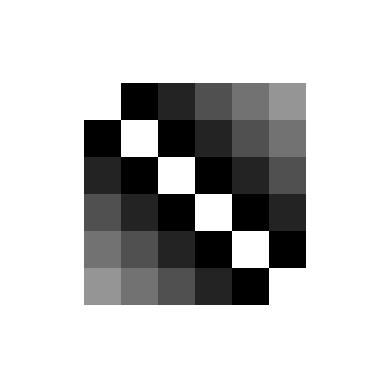

In [656]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

a = get_discount_matrix(10, rev=True, cor_supr_size=2)
a = np.array(a, dtype='float')
# a[:, 0:2] = 0
print(a)
show_image(a, cmap='Greys')

In [657]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [658]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


In [659]:
b = np.arange(8)
b[-2:] = 0
b[:2] = 0
b

array([0, 0, 2, 3, 4, 5, 0, 0])

In [660]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)

cor_supr_size = 0
ND = get_discount_matrix(W.shape[0], rev=True, cor_supr_size=cor_supr_size)
D = get_discount_matrix(W.shape[0], rev=False, cor_supr_size=cor_supr_size)
# np.fill_diagonal(NW, 0)
print('W', W.shape, W.max(), W.min(), np.median(W))

iter_cnt = 100 * 2

eps0 = 0.01
eps = eps0

for img in images[:1]:
    I = np.copy(img)
    print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

    # print(img)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    for iter_idx in range(iter_cnt):
        # eps = (iter_cnt - iter_idx) * eps0

        # infer
        DO = np.exp((I - W)**2 * -20.0)
        DO *= D # ** 2
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        dO /= np.max(dO)
        O += dO

        # O[np.where(O < 0)] = 0
        # O /= np.max(O)
        
        # O = O ** 2
        print(f'{np.max(O)=}')

        # inhibition
        NDO = np.exp((O - NW)**2 * -20.0)
        NDO *= ND # ** 0.5
        np.fill_diagonal(NDO, 0)
        # NDO = NDO ** 2
        dNO = np.sum(NDO, axis=1)
        dNO /= np.max(dNO)
        O -= dNO
        # O -= np.sum(NDO, axis=1) * 1.0

        O[np.where(O < 0)] = 0
        # O /= np.max(O)
        print(f'{np.max(O)=} {np.max(NDO)=}')

        # threshold = np.mean(O)
        # threshold = np.mean(O[np.where(O > 0)])

        cut_coef = 30
        O[-cut_coef:] = 0
        O[:cut_coef] = 0

        # inh train
        dNW = (O - NW) * eps # * dNO
        dNW[np.where(O <= 0)] = 0

        # inh update
        NW += dNW

        # train
        dW = (I - W) * eps # * dO
        dW[np.where(O <= 0)] = 0

        # update
        W += dW

        # stats
        SP.append(np.sum(O))
        MP.append(np.mean(O))
        CP.append(np.sum(O > 0))
        DP.append(np.sum(np.abs(I - W) + np.abs(O - NW)))

        # recur
        O /= np.max(O)

        I = np.copy(O)

        OST.append(np.copy(O))

print('W', W.shape, W.max(), W.min(), np.median(W))

W (784, 784) 0.9999980178275333 3.3426897405597344e-07 0.49980498838424264
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
np.max(O)=1.0
np.max(O)=0.3875862969462387 np.max(NDO)=781.9998524861278
np.max(O)=1.9726311959621379
np.max(O)=1.3303801025392024 np.max(NDO)=781.994225018055
np.max(O)=1.9725263130660582
np.max(O)=1.3253181542247225 np.max(NDO)=781.9999994597867
np.max(O)=1.970187418824891
np.max(O)=1.3179228490159032 np.max(NDO)=781.9998266570408
np.max(O)=1.9697582579838042
np.max(O)=1.3125059121649483 np.max(NDO)=781.9994497198448
np.max(O)=1.9722359647182552
np.max(O)=1.3102525430901624 np.max(NDO)=781.9986325058306
np.max(O)=1.9769422956767366
np.max(O)=1.3107140412776281 np.max(NDO)=781.9981837564237
np.max(O)=1.9830736242355487
np.max(O)=1.3130076557758978 np.max(NDO)=781.9997018296034
np.max(O)=1.9902305327653464
np.max(O)=1.3167465135404817 np.max(NDO)=781.9932841183271
np.max(O)=1.9980027493458974
np.max(O)=1.321487463018046 np.max(NDO)=781.9988388313487
np.max(

CP[-1]=10


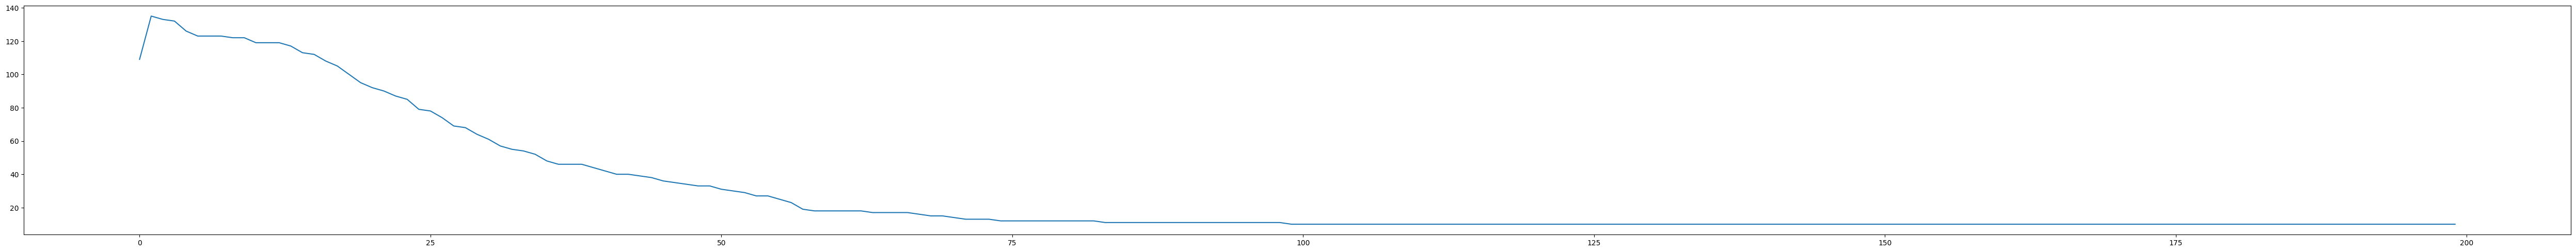

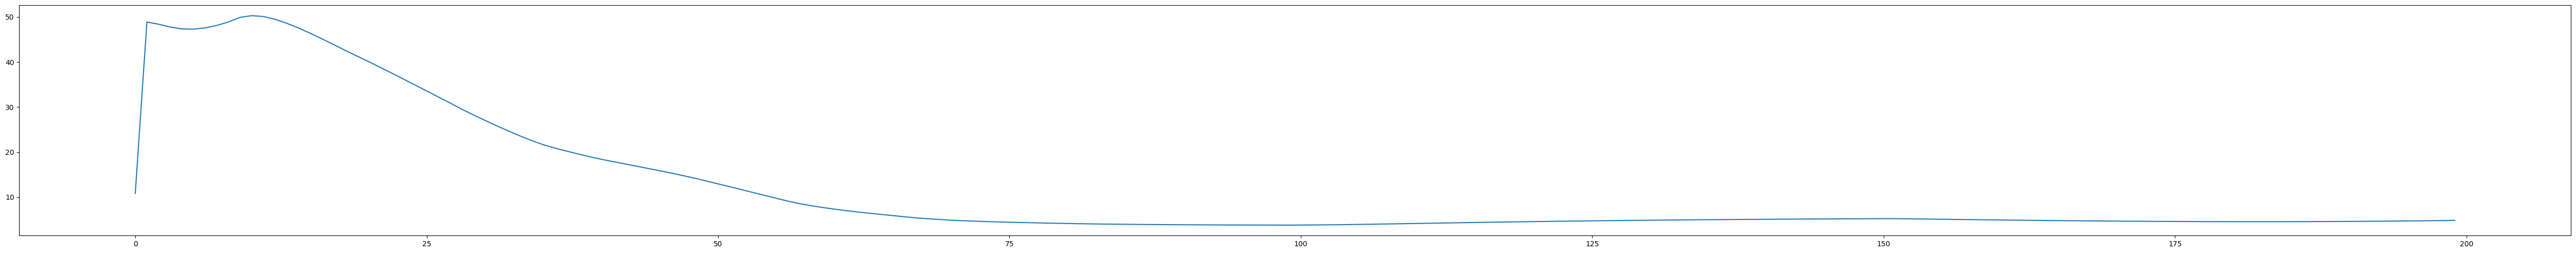

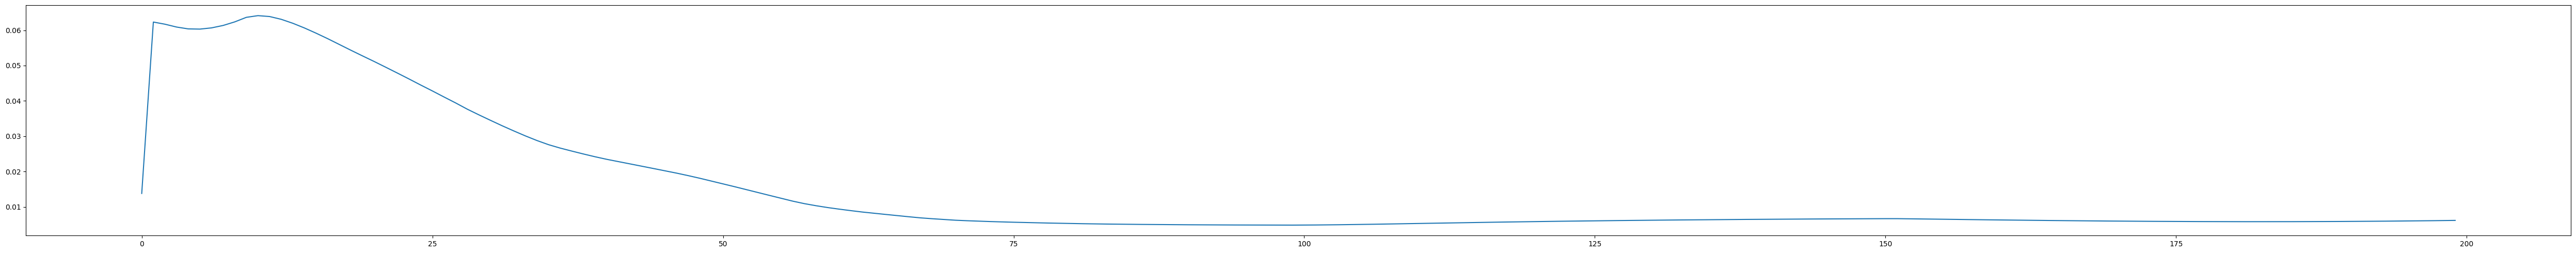

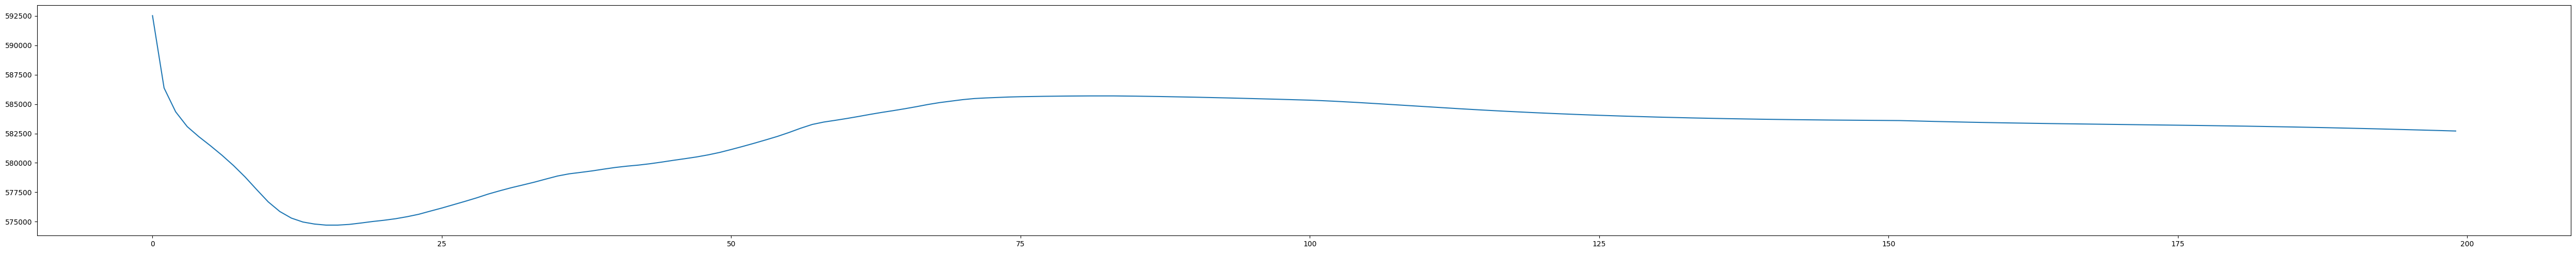

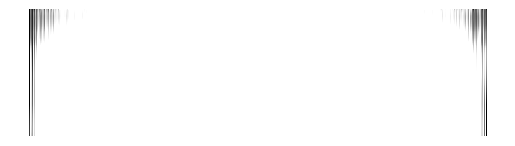

In [661]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

In [662]:
arr = np.array(MP[125:135])
arr = arr - np.pad(arr, (1, 0))[:-1]
CP[130]

10

In [663]:
CP[-40:-1]

[10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

i_T[-1]=0.0266953510609317


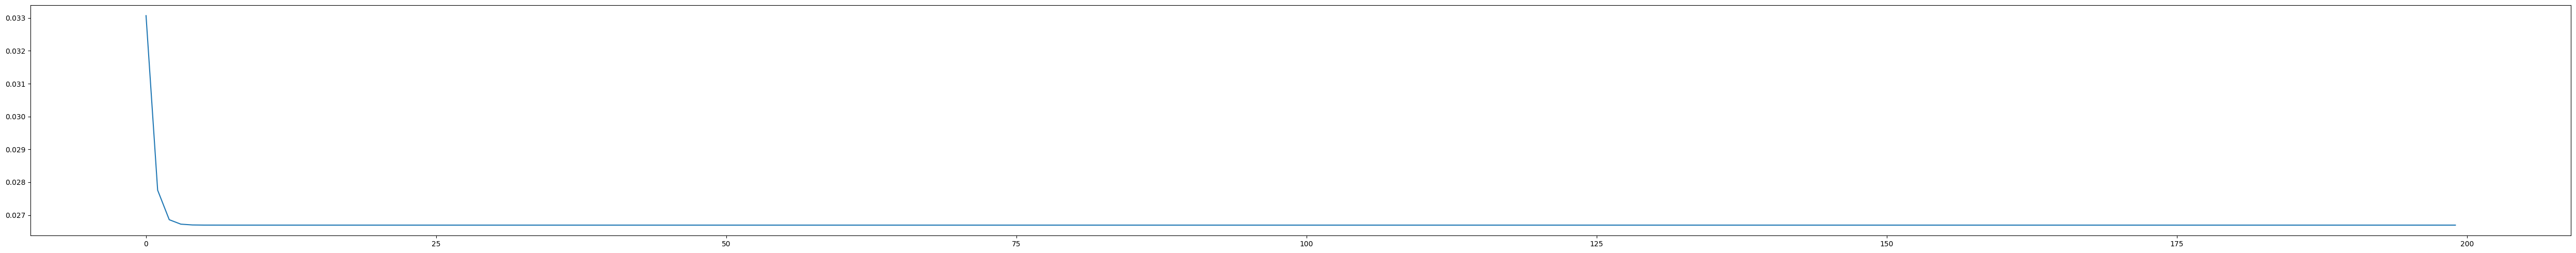

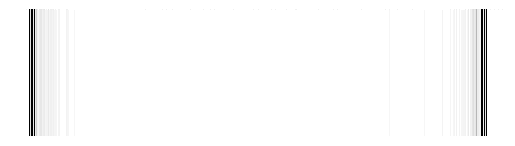

In [664]:
i_T, i_OST = infer(input=images[1], W=W, iter_cnt=iter_cnt)

print(f'{i_T[-1]=}')
simple_plot(T=i_T)

show_image(image=i_OST, cmap='Greys')

[[  0.   2.   4. ... 194. 196. 198.]
 [  2.   0.   2. ... 192. 194. 196.]
 [  4.   2.   0. ... 190. 192. 194.]
 ...
 [194. 192. 190. ...   0.   2.   4.]
 [196. 194. 192. ...   2.   0.   2.]
 [198. 196. 194. ...   4.   2.   0.]]


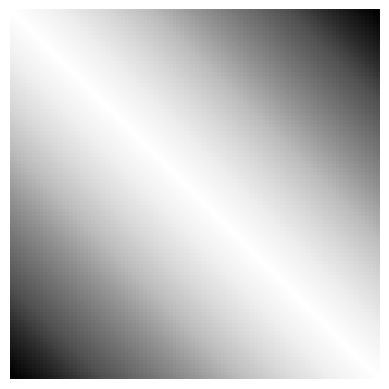

In [665]:
a = get_discount_matrix(100)
a = np.array(a, dtype='float')
a *= 2
print(a)
show_image(a, cmap='Greys')